In [ ]:
#-----------------BIGRAM MODEL (STATISTICAL)----------------

In [227]:
import torch

In [228]:
names = open('names.txt', 'r').read().splitlines()

In [229]:
chars = sorted(set('.'.join(names)))

itos = {i: c for i, c in enumerate(chars)}
stoi = {c: i for i, c in enumerate(chars)}

In [230]:
bigram = {}
for name in names:
    name = '.' + name + '.'
    for c1, c2 in zip(name, name[1:]):
        bigram[(c1,c2)] = bigram.get((c1, c2), 0) + 1

In [231]:
N = torch.zeros(27, 27)
for (c1, c2), count in bigram.items():
    N[stoi[c1]][stoi[c2]] = count

In [232]:
P = N / N.sum(dim=1, keepdim=True)

In [251]:
avg_loss = 0
count = 0
for name in names:
    name = '.' + name + '.'
    for c1, c2 in zip(name, name[1:]):
        ix = stoi[c1]
        ix2 = stoi[c2]
        loss = -torch.log(P[ix][ix2]).item()
        avg_loss += loss
        count += 1

avg_loss /= count
avg_loss

2.454014497322693

In [249]:
res = []

for _ in range(10):
    name = '.'
    while True:
        ix = stoi[name[-1]]
        nexti = torch.multinomial(P[ix], num_samples=1)[0].item()
        name += itos[nexti]
        if nexti == 0:
            res.append(name)
            break

res

['.me.',
 '.trienanatydaynavinouniai.',
 '.rtay.',
 '.h.',
 '.seti.',
 '.mamiomabretoush.',
 '.o.',
 '.tzibea.',
 '.ahasndahyasin.',
 '.si.']

In [253]:
#--------------BIGRAM THROUGH NEURAL NETWORK------------------

In [486]:
import torch
import torch.nn.functional as F

In [487]:
names = open('names.txt', 'r').read().splitlines()

In [488]:
chars = sorted(set('.'.join(names)))

itos = {i:c for i, c in enumerate(chars)}
stoi = {c:i for i, c in enumerate(chars)}

In [489]:

X, Y = [], []

for name in names:
    name = '.' + name + '.'
    for ch1, ch2 in zip(name, name[1:]):
        X.append(stoi[ch1])
        Y.append(stoi[ch2])

X = torch.tensor(X)
Y = torch.tensor(Y)

In [490]:
xenc = F.one_hot(X, num_classes=27).float()

In [491]:
W1 = torch.randn(27, 27).float()
b1 = torch.randn(27).float()
parameters = [W1, b1]

In [492]:
for p in parameters:
    p.requires_grad = True

In [632]:
for _ in range(10):
    h = torch.tanh(xenc @ W1 + b1)
    loss = F.cross_entropy(h, Y)
    print(loss)
    loss.backward()
    for p in parameters:
        p.data -= 1 * p.grad
        p.grad = None

tensor(2.6689, grad_fn=<NllLossBackward0>)
tensor(2.6689, grad_fn=<NllLossBackward0>)
tensor(2.6689, grad_fn=<NllLossBackward0>)
tensor(2.6689, grad_fn=<NllLossBackward0>)
tensor(2.6689, grad_fn=<NllLossBackward0>)
tensor(2.6689, grad_fn=<NllLossBackward0>)
tensor(2.6689, grad_fn=<NllLossBackward0>)
tensor(2.6689, grad_fn=<NllLossBackward0>)
tensor(2.6689, grad_fn=<NllLossBackward0>)
tensor(2.6689, grad_fn=<NllLossBackward0>)


In [638]:
res = []
for _ in range(10):
    name = '.'
    while True:
        xenc = F.one_hot(torch.tensor(stoi[name[-1]]), num_classes=27).float()
        h = torch.tanh(xenc @ W1 + b1).float()
        prob = F.softmax(h)
        nexti = torch.multinomial(prob, num_samples=1)[0].item()
        name += itos[nexti]
        if nexti == 0:
            res.append(name)
            break

res

/var/folders/7m/w8k84tcn19d4k10r234_g4lr0000gn/T/ipykernel_33405/479026107.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob = F.softmax(h)


['.nzonnveia.',
 '.kovxelll.',
 '.sbahe.',
 '.bryne.',
 '.ourxierj.',
 '..',
 '..',
 '.jeyconfemsgzlle.',
 '.jy.',
 '.aynnetdanpehver.']

In [154]:
#---------------------CHARACTER EMBEDDING VECTOR----------------------

In [155]:
import torch
import torch.nn.functional as F

In [156]:
names = open('names.txt', 'r').read().splitlines()

In [157]:
chars = sorted(set('.'.join(names)))

itos = {i: c for i, c in enumerate(chars)}
stoi = {c: i for i, c in enumerate(chars)}

In [158]:
context_len = 4
def build_dataset(names):
    X, Y = [], []
    for name in names:
        context = [0] * context_len
        name += '.'
        for ch in name:
            X.append(context)
            Y.append(stoi[ch])
            context = context[1:] + [stoi[ch]]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [203]:
n = int(len(names) * 0.8)

Xtr, Ytr = build_dataset(names[:n])

Xval, Yval = build_dataset(names[n:])

X, Y = build_dataset(names)

In [204]:
char_feature_count = 20

In [249]:
hidden_size = 200

C = torch.randn(27, char_feature_count)
W1 = torch.randn(context_len*char_feature_count, hidden_size) * (5/3)/(80**0.5)
# b1 = torch.randn(hidden_size) * 0.01
W2 = torch.randn(hidden_size, 27) * 0.01
b2 = torch.randn(27) * 0

bngain = torch.ones((1, hidden_size))
bnbias = torch.zeros((1, hidden_size))

bnmean_running = torch.zeros((1, hidden_size))
bnstd_running = torch.ones((1, hidden_size))

parameters = [C, W1, W2, b2, bngain, bnbias]

In [250]:
for p in parameters:
    p.requires_grad = True

In [251]:

for _ in range(50000):
    ix = torch.randint(0, Xtr.shape[0], (32,))
    emb = C[Xtr[ix]]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1
    bnmeani = hpreact.mean(dim=0, keepdim=True)
    bnstdi = hpreact.std(dim=0, keepdim=True)
    hpreact = bngain * ((hpreact - bnmeani) / bnstdi) + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    loss.backward()
    print(loss)
    for p in parameters:
        p.data -= 0.1 * p.grad
        p.grad = None


tensor(3.2877, grad_fn=<NllLossBackward0>)
tensor(3.2664, grad_fn=<NllLossBackward0>)
tensor(3.2975, grad_fn=<NllLossBackward0>)
tensor(3.2544, grad_fn=<NllLossBackward0>)
tensor(3.2082, grad_fn=<NllLossBackward0>)
tensor(3.1917, grad_fn=<NllLossBackward0>)
tensor(3.0949, grad_fn=<NllLossBackward0>)
tensor(3.1333, grad_fn=<NllLossBackward0>)
tensor(3.0370, grad_fn=<NllLossBackward0>)
tensor(3.0854, grad_fn=<NllLossBackward0>)
tensor(3.0348, grad_fn=<NllLossBackward0>)
tensor(3.1413, grad_fn=<NllLossBackward0>)
tensor(3.0524, grad_fn=<NllLossBackward0>)
tensor(3.1042, grad_fn=<NllLossBackward0>)
tensor(2.9522, grad_fn=<NllLossBackward0>)
tensor(2.9778, grad_fn=<NllLossBackward0>)
tensor(3.0650, grad_fn=<NllLossBackward0>)
tensor(2.9822, grad_fn=<NllLossBackward0>)
tensor(2.9689, grad_fn=<NllLossBackward0>)
tensor(3.1602, grad_fn=<NllLossBackward0>)
tensor(3.0369, grad_fn=<NllLossBackward0>)
tensor(2.8912, grad_fn=<NllLossBackward0>)
tensor(2.8830, grad_fn=<NllLossBackward0>)
tensor(2.95

In [238]:
emb = C[Xval]
embcat = emb.view(emb.shape[0], -1)
hpreact = embcat @ W1
hpreact = bngain * ((hpreact - bnmean_running) / bnstd_running) + bnbias
h = torch.tanh(hpreact)

logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yval)
print(loss)

tensor(2.3554, grad_fn=<NllLossBackward0>)


In [202]:
res = []
for _ in range(10):
    context = context_len * [0]
    name = ''
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(-1, context_len*char_feature_count) @ W1 + b1)
        
        logits = (h @ W2 + b2)
        prob = F.softmax(logits, dim=1)
        ix = torch.multinomial(prob, num_samples=1)[0].item()
        context = context[1:] + [ix]
        name += itos[ix]
        if ix == 0:
            res.append(name)
            break

res

['yasvina.',
 'zellor.',
 'kyrella.',
 'dayleah.',
 'coriani.',
 'jerics.',
 'kahni.',
 'marlette.',
 'kynze.',
 'marso.']

In [241]:
import matplotlib.pyplot as plt

(array([655088., 315403., 250745., 218702., 197452., 191040., 189784.,
        149099., 161730., 148875., 122431., 117433., 138657., 106098.,
        117380., 128649., 106494., 115543., 120225., 112137., 118926.,
        135052., 184295., 145084., 216779., 169201., 164502., 146520.,
        148681., 131137., 145640., 169424., 130450., 141270., 158844.,
        145494., 111458., 127464., 133624., 133299., 150259., 147096.,
        159283., 165762., 167866., 199388., 212115., 259155., 324370.,
        668197.]),
 array([-9.99999881e-01, -9.59999886e-01, -9.19999890e-01, -8.79999895e-01,
        -8.39999900e-01, -7.99999905e-01, -7.59999909e-01, -7.19999914e-01,
        -6.79999919e-01, -6.39999924e-01, -5.99999928e-01, -5.59999933e-01,
        -5.19999938e-01, -4.79999943e-01, -4.39999948e-01, -3.99999952e-01,
        -3.59999957e-01, -3.19999962e-01, -2.79999967e-01, -2.39999971e-01,
        -1.99999976e-01, -1.59999981e-01, -1.19999986e-01, -7.99999905e-02,
        -3.99999952e-02,  1.

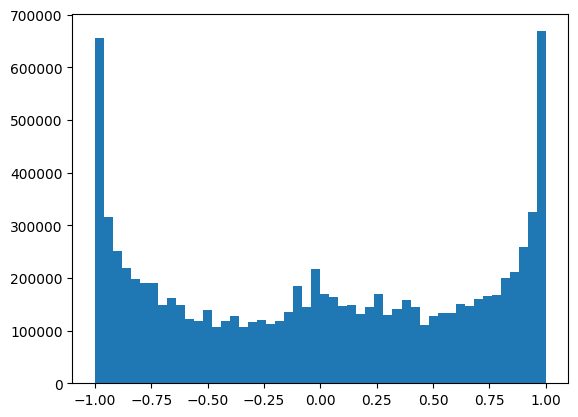

In [242]:
plt.hist(h.view(-1).tolist(), 50)